In [1]:
# importing necessary libraries
import pandas as pd
import pymysql
import requests
import matplotlib.pyplot as plt
import requests


In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

Content: Top 25 most used templates

In [4]:
query_url = "https://raw.githubusercontent.com/UshaKiran31/community-insights-dashboard-tooling/main/Content-Top%2025%20Most%20Used%20Templates.sql"
query = requests.get(query_url).text

In [5]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

# Loop and fetch data for each wiki
for wiki in wikis:
    output = connect_and_query(wiki, query)
    df = pd.DataFrame(output, columns=['template_name', 'usage_count'])
    df['wiki'] = wiki  # Add differentiation column
    all_dfs.append(df)

# Combine all into one dataframe
combined_df = pd.concat(all_dfs, ignore_index=True)

In [6]:
def decode_bytes(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    return val

for col in combined_df.columns:
    combined_df[col] = combined_df[col].apply(decode_bytes)

In [7]:
combined_df

,template_name,usage_count,wiki
0,Sitesupportpage,138685,tewiki
1,Gnunote,22140,tewiki
2,మొదటి_పేజీ_లింకులు,17205,tewiki
3,సుస్వాగతము,17200,tewiki
4,మార్గదర్శిని,16703,tewiki
...,...,...,...
70,മേയ്,741,mlwiki
71,CAL_SEP,703,mlwiki
72,Convert/Dual/LoutAoffD/SonNa,620,mlwiki
73,Geo_Stub,611,mlwiki


Editors: Number of editors with at least one edit (rolling YoY)

In [8]:
query_url = "https://raw.githubusercontent.com/UshaKiran31/community-insights-dashboard-tooling/main/Editors-Number%20of%20editors%20with%20at%20least%20one%20edit.sql"
query = requests.get(query_url).text

In [9]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

# Loop and fetch data for each wiki
for wiki in wikis:
    output = connect_and_query(wiki, query)
    df = pd.DataFrame(output, columns=['edit_year', 'active_editors'])
    df['wiki'] = wiki  # Add differentiation column
    all_dfs.append(df)

# Combine all into one dataframe
combined_df = pd.concat(all_dfs, ignore_index=True)

In [10]:
combined_df

,edit_year,active_editors,wiki
0,2025,839,tewiki
1,2024,1466,tewiki
2,2025,3639,hiwiki
3,2024,7904,hiwiki
4,2025,903,mlwiki
5,2024,2137,mlwiki


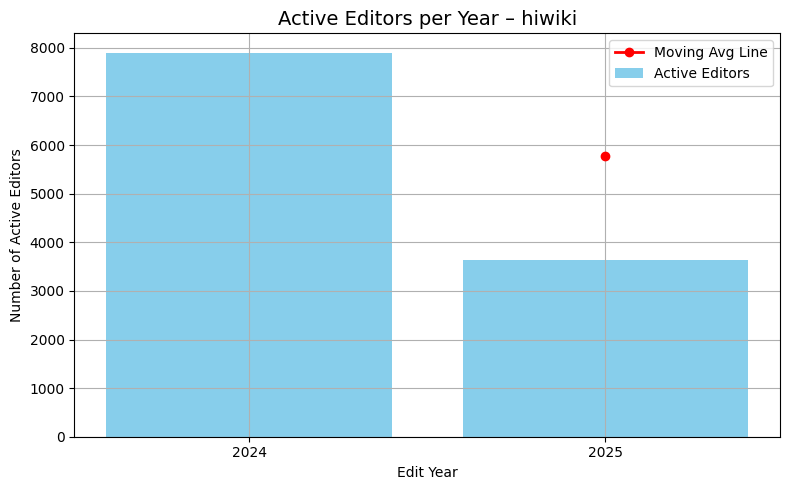

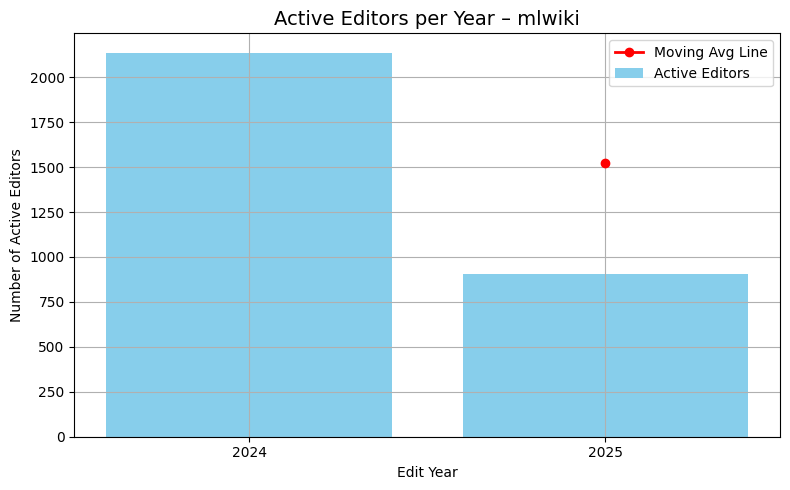

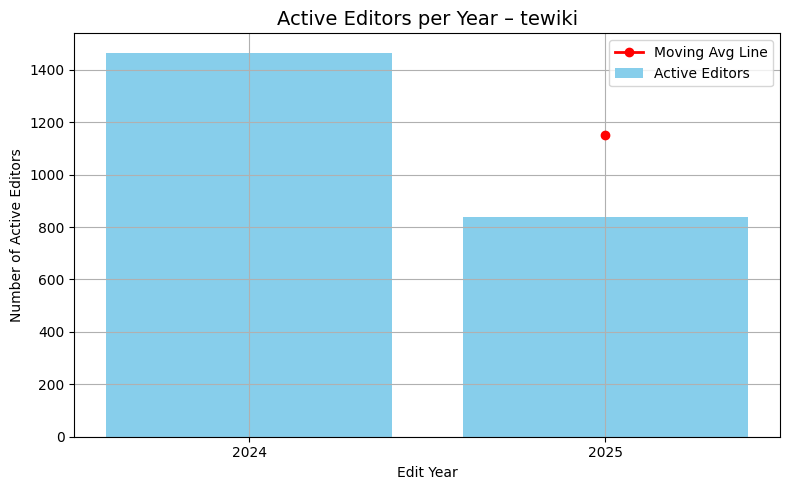

In [13]:
# Sort and calculate moving average
combined_df = combined_df.sort_values(by=['wiki', 'edit_year'])
combined_df['moving_avg'] = combined_df.groupby('wiki')['active_editors'].transform(lambda x: x.rolling(window=2).mean())

# Plot for each wiki 
for wiki in combined_df['wiki'].unique():
    df_wiki = combined_df[combined_df['wiki'] == wiki]

    plt.figure(figsize=(8, 5))
    plt.bar(df_wiki['edit_year'], df_wiki['active_editors'], color='skyblue', label='Active Editors')
    plt.plot(df_wiki['edit_year'], df_wiki['moving_avg'], color='red', marker='o', linewidth=2, label='Moving Avg Line')

    plt.xticks(df_wiki['edit_year'].unique())  # Show only distinct years like 2024, 2025

    plt.title(f'Active Editors per Year – {wiki}', fontsize=14)
    plt.xlabel('Edit Year')
    plt.ylabel('Number of Active Editors')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
